<a href="https://colab.research.google.com/github/vivekshaoutlook/machine_learning/blob/master/01_CalCOFI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#CalCOFI - California Cooperative Oceanic Fisheries Investigations.

from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score



In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
bottle = pd.read_csv("/content/drive/My Drive/bottle.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
bottle.head()

In [0]:
bottle.info()

In [0]:
#for retrieving multiple columns we pass a list.single column can be retrieved simply as bottle["Salnty"]
bottle_reduced_df = bottle[["Salnty","T_degC"]]
##comment the below line if training on full dataset
bottle_reduced_df = bottle_reduced_df#[:800]#################################
print(bottle_reduced_df.info())
print (bottle_reduced_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 2 columns):
Salnty    817509 non-null float64
T_degC    853900 non-null float64
dtypes: float64(2)
memory usage: 13.2 MB
None
   Salnty  T_degC
0  33.440   10.50
1  33.440   10.46
2  33.437   10.46
3  33.420   10.45
4  33.421   10.45


In [0]:
'''
Using the simpler random sampling than the Startified sampling since:
1. the reduced bottle Dataframe has only 2 columns on which we will work throughout
2. The number of dataset instances are very very large ~865K compared to number of features = 2
'''
train_set,test_set = train_test_split(bottle_reduced_df,test_size=0.2,random_state=42)
print("train set shape=",np.shape(train_set))
print("test set shape=",np.shape(test_set))

train set shape= (691890, 2)
test set shape= (172973, 2)


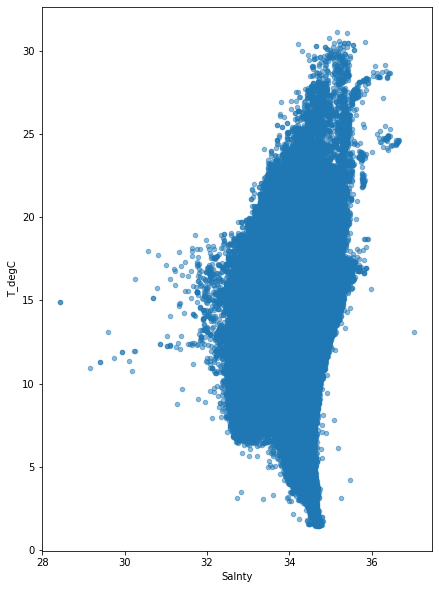

In [0]:
#let's do an scatter plot which is done using the traiing dataset
train_set.plot(kind="scatter",x="Salnty",y="T_degC",figsize=(7,10),alpha=0.5)

In [0]:
#the above plot showed some 'raw' correlation: but whether positive correlation, not clear
#let's plot correlation matrix
corr_matrix = train_set.corr()
corr_matrix["Salnty"]

Salnty    1.000000
T_degC   -0.505558
Name: Salnty, dtype: float64

There is a negative correlation between  Salnty and T_degC. 

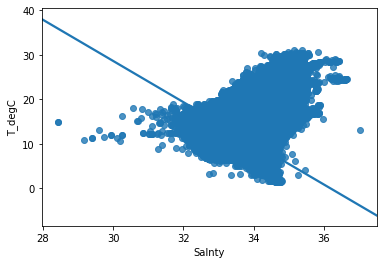

In [0]:

sns.regplot(x=train_set["Salnty"],y=train_set["T_degC"])

##Now the DATA CLEANING


In [0]:
#count the number of null for each column
train_set.isnull().sum(axis=0)

Salnty    37760
T_degC     8667
dtype: int64

In [0]:
#Replace the null by mean value. But, in a fancier way using pipeline :)
pipeline = Pipeline([
                     ("imputer",SimpleImputer(strategy="mean"))
])
train_set_tr = pipeline.fit_transform(train_set)


In [0]:
print(type(train_set_tr))
#the above pipeline transformation has actually returned a np array. So to convert back to DataFrame:
train_set_tr_df = pd.DataFrame(train_set_tr,index=train_set.index,columns=train_set.columns)
print(type(train_set_tr_df))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [0]:
#verify that the pipeline transformation was successfully done
train_set_tr_df.isnull().sum(axis=0)

Salnty    0
T_degC    0
dtype: int64

##Now Select & Train the model

In [0]:
#Let's try 3 models - First -->Linear Regressor
#If the training data has only one feature then need to do the below reshape before passing X to the model
X=train_set_tr_df['Salnty'].values.reshape(-1,1)
print(type(X))
print(np.shape(train_set_tr_df))
print(np.shape(X))
y=train_set_tr_df['T_degC']


<class 'numpy.ndarray'>
(691890, 2)
(691890, 1)


In [0]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)
predictions = lin_reg.predict(X)
mean_sq_error = mean_squared_error(y,predictions)
root_mean_sq_error = np.sqrt(mean_sq_error)
print("RMSE = ",root_mean_sq_error)

RMSE =  3.6765090023347122


*Let's use another model - DecisionTreeRegressor -  and analyze the performance


In [0]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X,y)
predictions = tree_reg.predict(X)
mean_sq_error = mean_squared_error(y,predictions)
root_mean_sq_error = np.sqrt(mean_sq_error)
print("RMSE = ",root_mean_sq_error)

RMSE =  3.11045662719082


So DecisionTreeRegressor did better than LinearRegression (oh, the naming anomalies). Now, let's see the performance with RandomForestRegressor. Hope, the RMSE will further come down

In [0]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X,y)
predictions = forest_reg.predict(X)
mean_sq_error = mean_squared_error(y,predictions)
root_mean_sq_error = np.sqrt(mean_sq_error)
print("RMSE = ",root_mean_sq_error)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE =  3.113111895605814


RMSE increased slightly with RandomForestRegressor.

---


Let's evaluate the 3 models further using the CV sets. Note that we are going to create CV from the training set itself. We will see that the RMSE on CV sets is same as RMSE on training set, so almost no overfitting


In [0]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("STd Dev:", scores.std())
  print("#######################")

model_array = [lin_reg,tree_reg,forest_reg]
for reg in model_array:
  scores = cross_val_score(reg,X,y,scoring="neg_mean_squared_error",cv=10)
  rmse_scores = np.sqrt(-scores)
  display_scores(rmse_scores)

Scores: [3.69235732 3.68109694 3.67224211 3.63370063 3.67906469 3.69543835
 3.67137673 3.68046853 3.67216049 3.68692877]
Mean: 3.6764834564067725
STd Dev: 0.016301307715001597
#######################
Scores: [3.17489172 3.15278069 3.15237632 3.11415236 3.14614641 3.17626152
 3.15839779 3.17099408 3.13196993 3.16422359]
Mean: 3.1542194398829126
STd Dev: 0.018663276356010366
#######################
Scores: [3.16991798 3.14814174 3.14948252 3.10939798 3.14152845 3.17373868
 3.15485883 3.16612127 3.12850511 3.16172579]
Mean: 3.150341835960863
STd Dev: 0.018884180399350813
#######################


#Now evaluate the model on Test Set using the best model - DecisionTreeRegressor

In [0]:
test_set_tr = pipeline.transform(test_set)
#convert back to DF
test_set_tr_df = pd.DataFrame(test_set_tr,index=test_set.index,columns=test_set.columns)
#verify no empty value on test set
test_set_tr_df.isnull().sum(axis=0)
#print(type(test_set_tr))
#print(test_set_tr)
X_test=test_set_tr_df['Salnty'].values.reshape(-1,1)
y_test=test_set_tr_df['T_degC']


final_predictions = tree_reg.predict(X_test)
final_mse = mean_squared_error(y_test,final_predictions)
print("MSE on Test Set = ",final_mse)
final_rmse = np.sqrt(final_mse)
print("RMSE on Test Set = ",final_rmse)

MSE on Test Set =  9.94255205899383
RMSE on Test Set =  3.1531812600917553


        Actual  Predicted
246454  10.250   7.029591
204226   3.760  10.262412
34578    5.270   7.062717
63034    9.930  10.078374
275018   9.360  13.489894
...        ...        ...
819723  10.380  13.781648
259856  11.780  13.762314
87776    9.690   9.748082
695655   9.240   7.907803
839180   5.574   6.549333

[172973 rows x 2 columns]


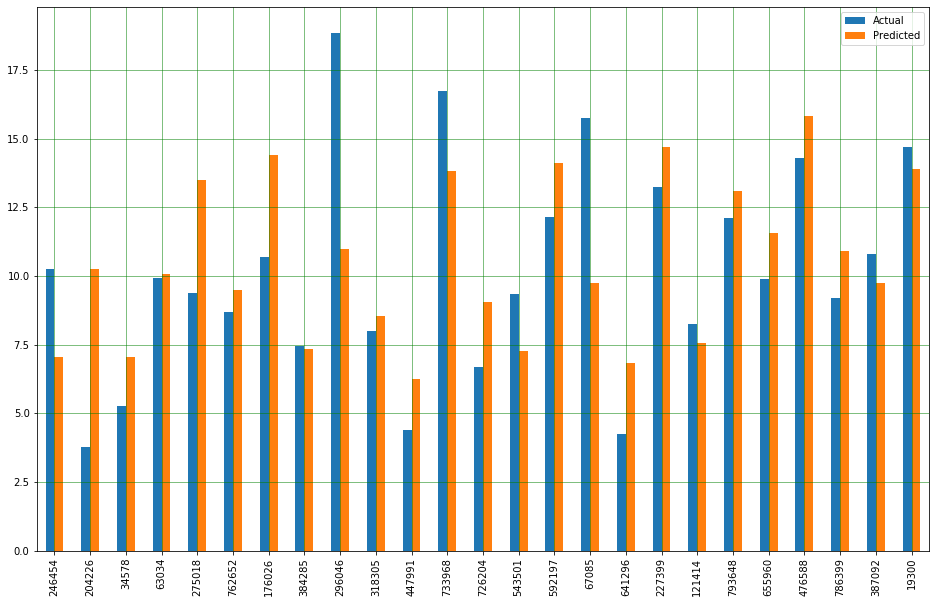

In [0]:
test_df = pd.DataFrame({'Actual': y_test, 'Predicted': final_predictions})
print(test_df)
#plotting only the first 25 values
df_plot = test_df.head(25)
df_plot.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()